## Required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil, cv2, time
import pandas as pd
import pickle

import keras
from keras import backend as K
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications import InceptionResNetV2, Xception
from keras.layers import Dense, Activation
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from sklearn.metrics import accuracy_score, roc_curve
import random

%matplotlib inline

Using TensorFlow backend.


### defind necessary variable

In [2]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

## Data description and preprocessing

Read image file from directory and create dataframe for the data with 2 columns:
    * image = image name
    * label = class of the images (dog, cat, and other)

In [3]:
raw_train_dir =os.listdir( "./dataset/train/")
labels = []

for filename in raw_train_dir:
    label = filename.split('.')[0]
    if label == 'dog':
        labels.append("dog")
    elif label == 'cat':
        labels.append("cat")
    else:
        labels.append("other")

df = pd.DataFrame({
    'image': raw_train_dir,
    'label': labels
})

In [4]:
df

,image,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat
5,cat.10000.jpg,cat
6,cat.10001.jpg,cat
7,cat.10002.jpg,cat
8,cat.10003.jpg,cat
9,cat.10004.jpg,cat


Visualize the number of records for each class in the dataframe.

In [5]:
df['label'].value_counts()

other    12500
dog      12500
cat      12500
Name: label, dtype: int64

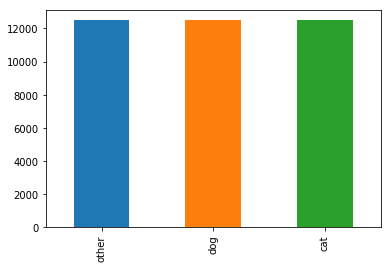

In [6]:
#Plot graph to show number of records for each class in the dataframe.
df['label'].value_counts().plot.bar()

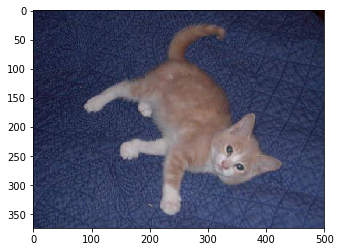

In [7]:
#Sample the image from directory
sample = random.choice(raw_train_dir)
image = load_img("./dataset/train/"+sample)
plt.imshow(image)

I seperated data into traningset and validateset by using train_test_split function to get a dataset for each traningset and validateset.

    * Training-set   = 28,1250 samples
    * Validation-set = 9,375 samples

In [8]:
trainset, validateset = train_test_split(df, test_size=0.25, random_state=48)
trainset = trainset.reset_index()
validateset = validateset.reset_index()
total_trainset = trainset.shape[0]
total_validateset = validateset.shape[0]

In [9]:
trainset['label'].value_counts()

dog      9402
other    9369
cat      9354
Name: label, dtype: int64

Prepare ImageDataGenerator that generate batches of tensor image data with real-time data augmentation.

For the train and validation generator, I rescale, flip, and rotate the image that pass through the generator.

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    trainset, 
    "./dataset/train/", 
    x_col='image',
    y_col='label',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 28125 images belonging to 3 classes.


In [11]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validateset, 
    "./dataset/train/", 
    x_col='image',
    y_col='label',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 9375 images belonging to 3 classes.


Sample some image from trainset

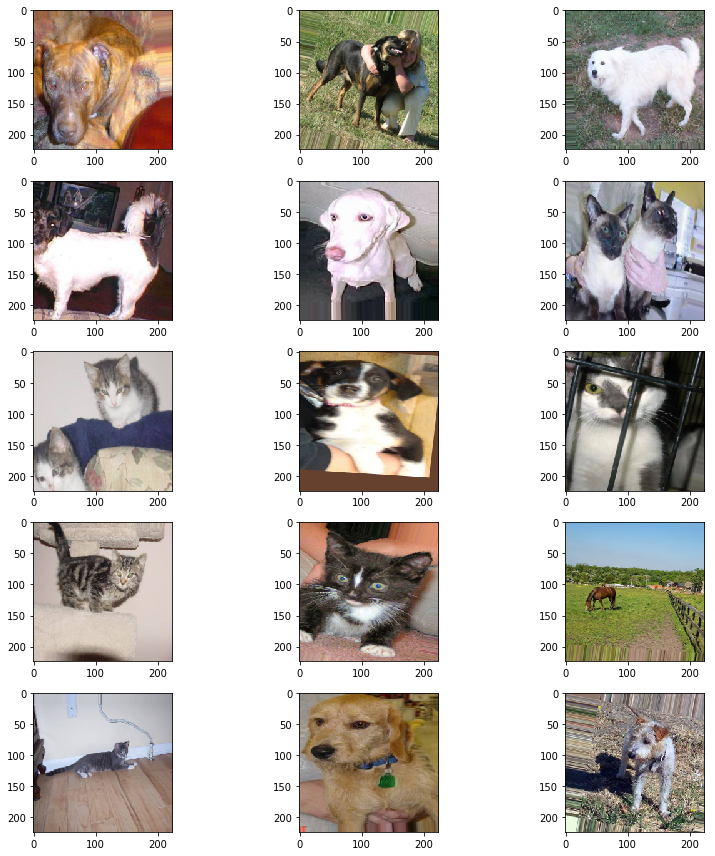

In [12]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Modeling and compilation


In [13]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D, BatchNormalization
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16,VGG19
from keras.models import Model

# Model1 CNN model
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(512, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(3, activation='softmax')) # 2 because we have cat and dog classes

model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
__________

In [15]:
# Model2 VGG19 Pretrained model with adding new fully-connected
# Create the pretraining VGG19 model, pop out the last dense layer
base_model2 = VGG19(input_shape=input_shape, include_top=False, weights="imagenet")

# Freeze weight of VGG19 layers (untrainable)
base_model2.trainable = False

model2 = models.Sequential()
model2.add(base_model2)
model2.add(GlobalMaxPooling2D())
model2.add(layers.Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(layers.Dense(3, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 20,290,627
Trainable params: 265,219
Non-trainable params: 20,025,408
__________________________________________________________

In [16]:
# Model3 pretrained InceptionResNetV2 with adding fully-connected
# Create the pretraining InceptionV2 model, pop out the last dense layer
base_model3 = InceptionResNetV2(include_top=False, input_shape=input_shape)

# Freeze weight of InceptionResNetV2 layers (untrainable)
base_model3.trainable = False

# Add our Dense layers for classificaton
model3 = models.Sequential()
model3.add(base_model3)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(3, activation='sigmoid'))

# Optimizer, loss and metrics
model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               9830656   
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 64,168,163
Trainable params: 9,831,427
Non-trainable params: 54,336,736
_________________________________________________________________


In [14]:
K.clear_session()
# Model4 VGG19 Pretrained model with adding new fully-connected and drop-out
# Create the pretraining VGG19 model, pop out the last dense layer
base_model4 = VGG19(input_shape=input_shape, include_top=False, weights="imagenet")

model4 = models.Sequential()

# Freeze weight of VGG19 layer 1-15 (untrainable)
for base_layer in base_model4.layers[:15]:
    base_layer.trainable = False
    model4.add(base_layer)
for base_layer in base_model4.layers[15:21]:
    base_layer.trainable = True
    model4.add(base_layer)


# model4.add(base_model4)
# model4.add(MaxPooling2D())
model4.add(GlobalMaxPooling2D())
model4.add(Dense(512, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))
model4.add(Dense(3, activation='softmax'))

model4.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# model2.summary()
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

## Training and Validation

Train every models with 10 epochs and batch size of 16. And I used 'fit_generator' for feeding data from generator that I define above to models

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [18]:
history1 = model1.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validateset//batch_size,
    steps_per_epoch=total_trainset//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1757/1757 [==============================] - 593s 337ms/step - loss: 0.8421 - acc: 0.6355 - val_loss: 1.3487 - val_acc: 0.5080
Epoch 2/10
1757/1757 [==============================] - 535s 305ms/step - loss: 0.5599 - acc: 0.7617 - val_loss: 0.8038 - val_acc: 0.6871
Epoch 3/10
1757/1757 [==============================] - 550s 313ms/step - loss: 0.4798 - acc: 0.8035 - val_loss: 0.5956 - val_acc: 0.7622
Epoch 4/10
1757/1757 [==============================] - 554s 316ms/step - loss: 0.4187 - acc: 0.8372 - val_loss: 2.0944 - val_acc: 0.3536
Epoch 5/10
1757/1757 [==============================] - 550s 313ms/step - loss: 0.3777 - acc: 0.8540 - val_loss: 1.2292 - val_acc: 0.6302

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
1757/1757 [==============================] - 556s 317ms/step - loss: 0.3090 - acc: 0.8820 - val_loss: 0.2663 - val_acc: 0.8991
Epoch 7/10
1757/1757 [==============================] - 551s 313ms/step - loss: 0.2768 - ac

In [19]:
model_name="CNN.hdf5"
model1.save(model_name)

In [20]:
# fine-tune the model
from keras.callbacks import ModelCheckpoint
filepath="Image_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history2 = model2.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_validateset//batch_size,
    steps_per_epoch=total_trainset//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1757/1757 [==============================] - 606s 345ms/step - loss: 0.5942 - acc: 0.7043 - val_loss: 0.3574 - val_acc: 0.8487
Epoch 2/10
1757/1757 [==============================] - 681s 388ms/step - loss: 0.4548 - acc: 0.7882 - val_loss: 0.3114 - val_acc: 0.8728
Epoch 3/10
1757/1757 [==============================] - 615s 350ms/step - loss: 0.4075 - acc: 0.8157 - val_loss: 0.2849 - val_acc: 0.8867
Epoch 4/10
1757/1757 [==============================] - 615s 350ms/step - loss: 0.3815 - acc: 0.8307 - val_loss: 0.2721 - val_acc: 0.8938
Epoch 5/10
1757/1757 [==============================] - 617s 351ms/step - loss: 0.3658 - acc: 0.8385 - val_loss: 0.2604 - val_acc: 0.8988
Epoch 6/10
1757/1757 [==============================] - 611s 348ms/step - loss: 0.3526 - acc: 0.8445 - val_loss: 0.2515 - val_acc: 0.9023
Epoch 7/10
1757/1757 [==============================] - 587s 334ms/step - loss: 0.3422 - acc: 0.8508 - val_loss: 0.2462 - val_acc: 0.9045
Epoch 8/10
1757/1757 [============

In [21]:
model_name="VGG19_Pretrain.hdf5"
model2.save(model_name)

In [22]:
history3 = model3.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_validateset//batch_size,
    steps_per_epoch=total_trainset//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1757/1757 [==============================] - 619s 353ms/step - loss: 3.9689 - acc: 0.7504 - val_loss: 3.8197 - val_acc: 0.7615
Epoch 2/10
1757/1757 [==============================] - 614s 349ms/step - loss: 3.8691 - acc: 0.7578 - val_loss: 2.4024 - val_acc: 0.8418
Epoch 3/10
1757/1757 [==============================] - 600s 341ms/step - loss: 0.3079 - acc: 0.9424 - val_loss: 0.3161 - val_acc: 0.9590
Epoch 4/10
1757/1757 [==============================] - 611s 348ms/step - loss: 0.1707 - acc: 0.9557 - val_loss: 0.2282 - val_acc: 0.9739
Epoch 5/10
1757/1757 [==============================] - 604s 344ms/step - loss: 0.1585 - acc: 0.9588 - val_loss: 0.3927 - val_acc: 0.9543
Epoch 6/10
1757/1757 [==============================] - 617s 351ms/step - loss: 0.1511 - acc: 0.9613 - val_loss: 0.2351 - val_acc: 0.9712

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/10
1757/1757 [==============================] - 612s 348ms/step - loss: 0.1190 - ac

In [23]:
model_name="InceptionResNetV2_Pretrain.hdf5"
model3.save(model_name)

In [16]:
# fine-tune the model
from keras.callbacks import ModelCheckpoint

history4 = model4.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_validateset//batch_size,
    steps_per_epoch=total_trainset//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1757/1757 [==============================] - 540s 307ms/step - loss: 0.7251 - acc: 0.6691 - val_loss: 0.3934 - val_acc: 0.8443
Epoch 2/10
1757/1757 [==============================] - 534s 304ms/step - loss: 0.3686 - acc: 0.8624 - val_loss: 0.2946 - val_acc: 0.8896
Epoch 3/10
1757/1757 [==============================] - 520s 296ms/step - loss: 0.2866 - acc: 0.8978 - val_loss: 0.4651 - val_acc: 0.8429

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
1757/1757 [==============================] - 639s 364ms/step - loss: 0.2453 - acc: 0.9124 - val_loss: 0.1588 - val_acc: 0.9454
Epoch 5/10
1757/1757 [==============================] - 499s 284ms/step - loss: 0.2074 - acc: 0.9272 - val_loss: 0.2115 - val_acc: 0.9301

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/10
1757/1757 [==============================] - 554s 315ms/step - loss: 0.1806 - acc: 0.9374 - val_loss: 0.1490 - val_acc: 0.9501
Epoch 7/10

In [30]:
model_name="best_cat_dog_model.h5"
model4.save(model_name)

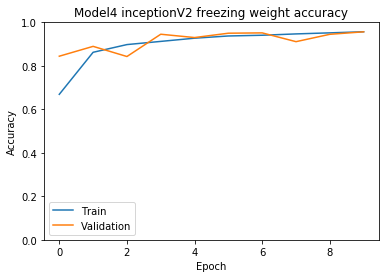

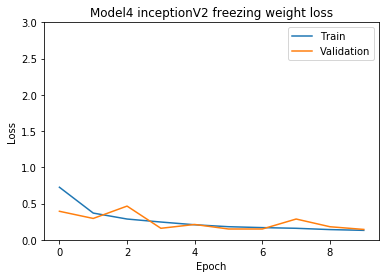

In [17]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Model4 VGG19 freezing weight accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.figure()
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model4 VGG19 freezing weight loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 3])
plt.legend(['Train', 'Validation'])
plt.show()

## Evaluation and select the best model

Prepare test data set for evaluate the model.

In [18]:
test_filenames = os.listdir("./dataset/test_set/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

2423

In [20]:
test_gen = ImageDataGenerator(rescale=1./224)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./dataset/test_set/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    shuffle=False
)

Found 2423 images.


In [21]:
test_df1=test_df
test_df2=test_df
test_df3=test_df
test_df4=test_df

In [28]:
predict1 = model1.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size), verbose=1)

152/152 [==============================] - 41s 271ms/step


In [29]:
predict2 = model2.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size), verbose=1)

152/152 [==============================] - 38s 247ms/step


In [30]:
predict3 = model3.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size), verbose=1)

152/152 [==============================] - 37s 245ms/step


In [22]:
predict4 = model4.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size), verbose=1)

152/152 [==============================] - 40s 262ms/step


In [33]:
test_df1['label'] = np.argmax(predict1, axis=-1)

In [34]:
test_df2['label'] = np.argmax(predict2, axis=-1)

In [35]:
test_df3['label'] = np.argmax(predict3, axis=-1)

In [24]:
test_df4['label'] = np.argmax(predict4, axis=-1)

In [25]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df1['label'] = test_df1['label'].replace(label_map)

In [37]:
test_df2['label'] = test_df2['label'].replace(label_map)

In [38]:
test_df3['label'] = test_df3['label'].replace(label_map)

In [26]:
test_df4['label'] = test_df4['label'].replace(label_map)

In [105]:
test_df1['label'].value_counts()

other    1019
cat       851
dog       553
Name: label, dtype: int64

In [40]:
test_df2['label'].value_counts()

cat      959
dog      897
other    567
Name: label, dtype: int64

In [41]:
test_df3['label'].value_counts()

cat      959
dog      897
other    567
Name: label, dtype: int64

From my experiment the best model that I have tried is model4 with hige accuracy.

Use the model4 to classify your given test set.

In [27]:
test_df4['label'].value_counts()

cat      930
other    784
dog      709
Name: label, dtype: int64

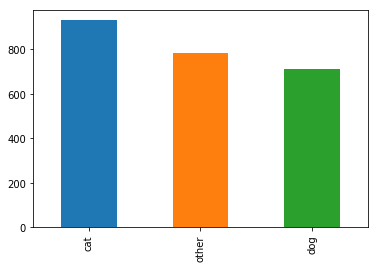

In [28]:
# Plot graph
test_df4['label'].value_counts().plot.bar()

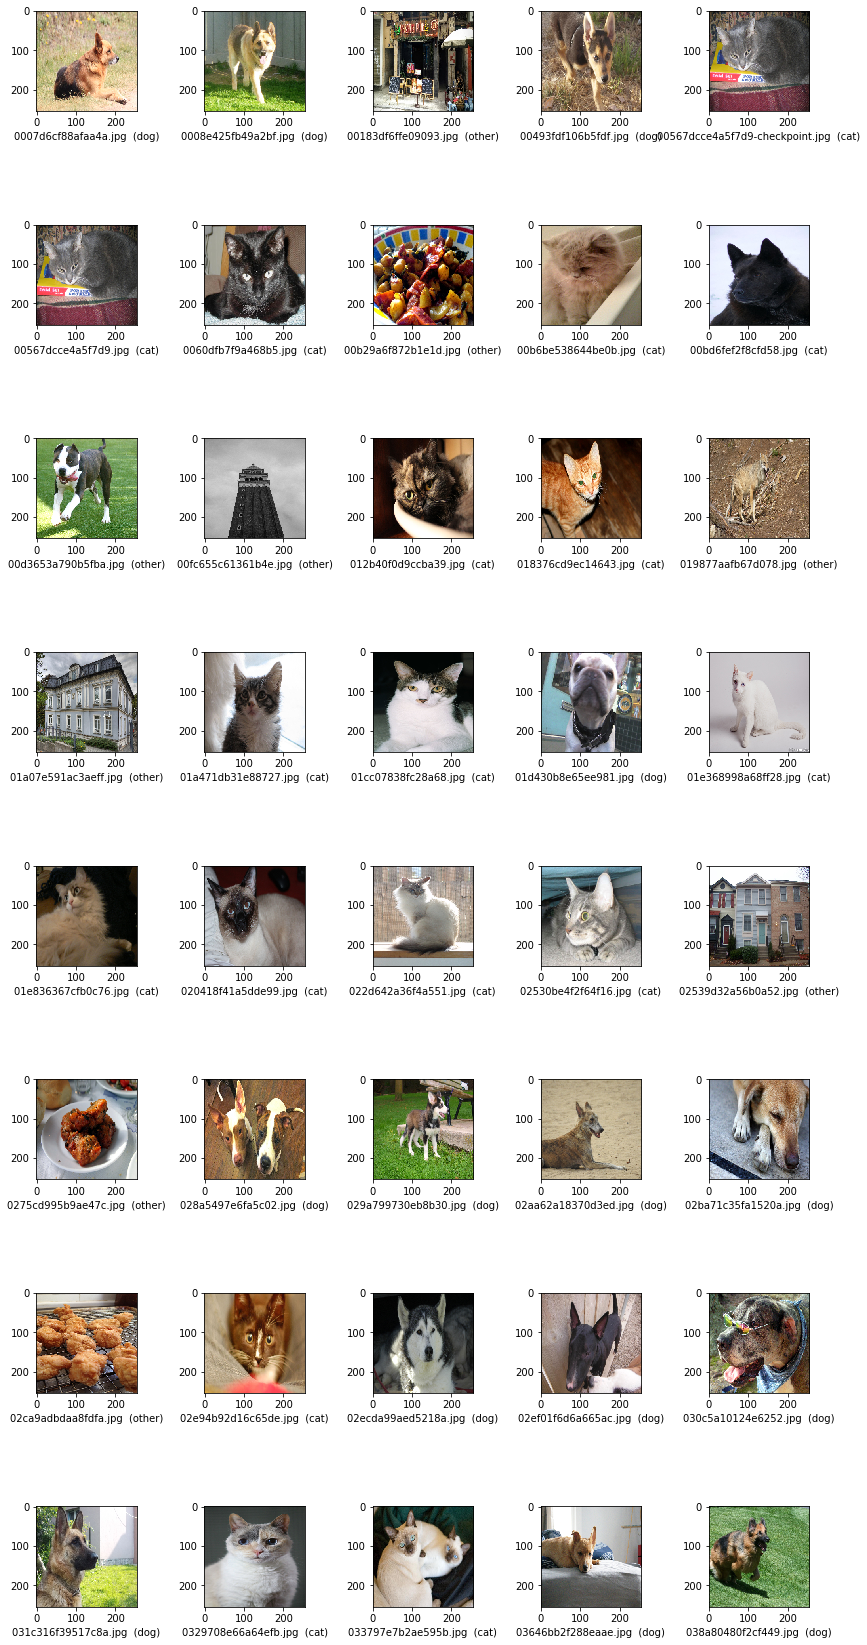

In [29]:
sample_test = test_df4.head(40)
sample_test
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['label']
    img = load_img("./dataset/test_set/"+filename, target_size=(255,255))
    plt.subplot(8, 5, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '  (' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [38]:
# Save the result to csv file
final_df = test_df4.copy()
final_df['file'] = final_df['filename'].str.split('.').str[0]
final_df['category'] = final_df['label']
final_df.drop(['filename', 'label'], axis=1, inplace=True)
final_df.to_csv("Dog_Cat_Result.csv", index=False)